In [1]:
import cv2, glob, time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
train_img = glob.glob('./train/*_input.jpg')
train_mask = glob.glob('./train/*_target.jpg')
train_img.sort(); train_mask.sort()

In [3]:
len(train_img)

5000

In [4]:
cv2.imread(train_mask[0]).shape

(512, 512, 3)

In [5]:
cv2.imread(train_img[0]).shape

(512, 512, 3)

In [6]:
class FoodDataset(D.Dataset):
    def __init__(self, images, masks, transform):
        self.images = images
        self.masks = masks
        
        self.transform = transform
        self.as_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])
        

    # get data operation
    def __getitem__(self, index):
        image, mask = cv2.imread(self.images[index]), cv2.imread(self.masks[index])
        mask = np.transpose(mask, (2, 0, 1))
        # transpose((2, 0, 1))
        
        # augments = self.transform(image=image, mask=mask)
        return self.as_tensor(image), mask / 255.0
        # return augments['image'], augments['mask'][None]

    def __len__(self):
        return len(self.images)


trfm = A.Compose([
    A.Resize(512,512),
    # A.HorizontalFlip(p=0.5, is_check_shapes=False),
    # A.VerticalFlip(p=0.5, is_check_shapes=False),
    
    # A.OneOf([
    #     A.RandomGamma(),
    #     A.ColorJitter(brightness=0.07, contrast=0.07,
    #                saturation=0.1, hue=0.1, always_apply=False, p=0.3),
    #     ], p=0.3),
    # A.OneOf([
    #     A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #     A.GridDistortion(),
    #     A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
    #     ], p=0.0),
    # A.ShiftScaleRotate(),
])

train_ds = FoodDataset(train_img[:-200], train_mask[:-200], transform=trfm)


trfm = A.Compose([
    A.Resize(512,512),
])
val_ds = FoodDataset(train_img[-200:], train_mask[-200:], transform=trfm)

In [7]:
train_ds[0][1].shape

(3, 512, 512)

In [8]:
train_loader = D.DataLoader( train_ds, batch_size=8, shuffle=True, num_workers=3)
val_loader = D.DataLoader( val_ds, batch_size=8, shuffle=False, num_workers=3)

## Unet

In [9]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3
)

# model = smp.DeepLabV3(
#     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=103,                      # model output channels (number of classes in your dataset)
# )

100%|██████████| 600/600 [02:04<00:00,  4.84it/s]


Epoch 1/10
Train Loss: 0.0633, Validation Loss: 0.0329
Time: 2.10 minutes



100%|██████████| 600/600 [02:04<00:00,  4.84it/s]


Epoch 2/10
Train Loss: 0.0318, Validation Loss: 0.0326
Time: 2.10 minutes



100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


Epoch 3/10
Train Loss: 0.0290, Validation Loss: 0.0274
Time: 2.11 minutes



100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


Epoch 4/10
Train Loss: 0.0268, Validation Loss: 0.0306
Time: 2.11 minutes



100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


Epoch 5/10
Train Loss: 0.0254, Validation Loss: 0.0257
Time: 2.11 minutes



100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


Epoch 6/10
Train Loss: 0.0231, Validation Loss: 0.0254
Time: 2.11 minutes



100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


Epoch 7/10
Train Loss: 0.0218, Validation Loss: 0.0288
Time: 2.11 minutes



100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


Epoch 8/10
Train Loss: 0.0198, Validation Loss: 0.0257
Time: 2.11 minutes



100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


Epoch 9/10
Train Loss: 0.0183, Validation Loss: 0.0259
Time: 2.11 minutes



100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


Epoch 10/10
Train Loss: 0.0171, Validation Loss: 0.0251
Time: 2.11 minutes



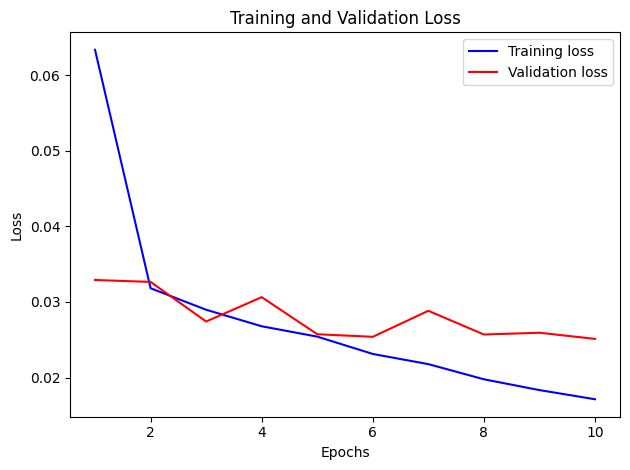

In [10]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    total_correct = 0
    total_samples = 0
    miou_scores = []
    model.eval()
    for image, target in loader:
        image, target = image.to('cuda'), target.to('cuda').float()
        output = model(image)
        loss = loss_fn(output, target)
        losses.append(loss.item())
                
    avg_loss = np.array(losses).mean()
    
    return avg_loss

model.to('cuda');
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bce_fn = nn.MSELoss()
# bce_fn = MultiClassDiceLoss()

EPOCHES = 10
train_losses = []
val_losses = []
accuracies = []
mious = []

for epoch in range(1, EPOCHES + 1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm(train_loader):
        image, target = image.to('cuda'), target.to('cuda').float()
        optimizer.zero_grad()
        output = model(image)
        loss = bce_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    avg_train_loss = np.mean(losses)
    avg_loss = validation(model, val_loader, bce_fn)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_loss)
    
    print(f"Epoch {epoch}/{EPOCHES}")
    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_loss:.4f}")
    print(f"Time: {(time.time() - start_time) / 60:.2f} minutes\n")

epochs = range(1, EPOCHES + 1)
plt.figure()
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
output.shape, target.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 3, 512, 512]))

In [17]:
model.eval()
for image, target in val_loader:
    image, target = image.to('cuda'), target.to('cuda').float()
    output = model(image)
    break

In [18]:
output = (output.data.cpu().numpy() * 255).astype(np.uint8)
output = output[3]
output = np.transpose(output, (1,2, 0))

target = (target.data.cpu().numpy() * 255).astype(np.uint8)
target = target[3]
target = np.transpose(target, (1,2, 0))

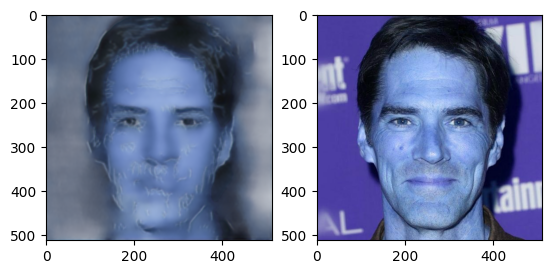

In [19]:
plt.subplot(121)
plt.imshow(output)

plt.subplot(122)
plt.imshow(target)

In [23]:
trfm = A.Compose([
    A.Resize(512,512),
])
test_img = glob.glob('./test/*_input.jpg')
test_img.sort()
test_ds = FoodDataset(test_img, test_img, transform=trfm)
test_loader = D.DataLoader( test_ds, batch_size=8, shuffle=False, num_workers=3)

In [29]:
!mkdir submit

In [40]:
model.eval()
idx = 0
with torch.no_grad():
    for image, target in test_loader:
        image, target = image.to('cuda'), target.to('cuda').float()
        outputs = model(image)
        outputs = (outputs.data.cpu().numpy() * 255).astype(np.uint8)
        for output in outputs:
            output = np.transpose(output, (1,2, 0))
            cv2.imwrite('submit/' + test_img[idx].split('/')[-1].replace('input', 'target'), output)
            idx += 1

In [41]:
!ls -l submit | wc -l
!ls -l test | wc -l

1501
1501


In [42]:
!zip -r submit.zip submit

  adding: submit/ (stored 0%)
  adding: submit/7004a3dd-f242-4b1a-83f4-fbec22e66b7f_target.jpg (deflated 1%)
  adding: submit/841ac922-5950-4718-95e0-2a7b9da8a9cf_target.jpg (deflated 0%)
  adding: submit/d2ded8f2-8bec-4035-95f1-94f89cccb982_target.jpg (deflated 1%)
  adding: submit/22aa21ac-f423-47e9-bebc-6999c6aac8f8_target.jpg (deflated 0%)
  adding: submit/4ca34784-ff99-4832-8f58-0bb7b9384b3d_target.jpg (deflated 0%)
  adding: submit/ce74cc10-826d-4a45-af0a-fe85a7fe4822_target.jpg (deflated 0%)
  adding: submit/c5156ede-c149-411a-836d-a4edccddf76c_target.jpg (deflated 1%)
  adding: submit/f355b820-dcc7-40d2-ac89-014ea03fefe4_target.jpg (deflated 0%)
  adding: submit/1030db1b-06c6-4b19-9c72-2461f01e1e2a_target.jpg (deflated 0%)
  adding: submit/5433ca06-eda5-41ae-a860-eb16ff074557_target.jpg (deflated 0%)
  adding: submit/4eceda6c-ef69-4277-b117-bb116ec59108_target.jpg (deflated 0%)
  adding: submit/4782b2f2-4e50-4924-9789-3a58bbfcc61b_target.jpg (deflated 0%)
  adding: submit/3c1f6